In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import math
import re
import plotly.express as px
import statsmodels.api as sm
import sys
from sqlalchemy import create_engine
import psycopg2
import catboost as catt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

train.sort_values(['date','city'],inplace=True)
test.sort_values(['date','city'],inplace=True)

train['date_day'] = train['date'].dt.day_of_year
train['date_month'] = train['date'].dt.month

test['date_day'] = test['date'].dt.day_of_year
test['date_month'] = test['date'].dt.month

x = train[['date_day','pm2_5']].groupby('date_day').aggregate('mean')


In [5]:
city_list = train['city'].unique()
country_list =  train['country'].unique()
print(city_list)
print(country_list)


['Kampala' 'Nairobi' 'Lagos' 'Bujumbura']
['Uganda' 'Kenya' 'Nigeria' 'Burundi']


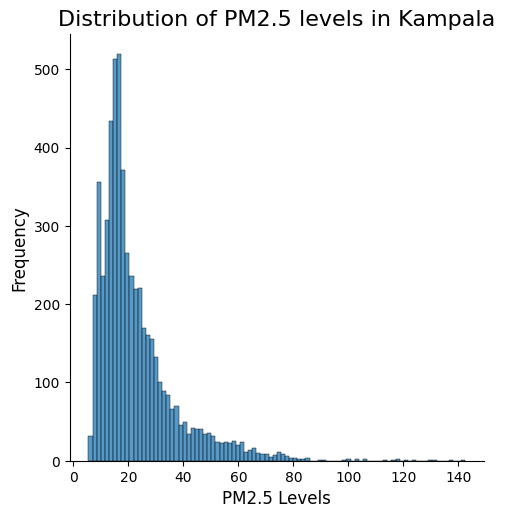

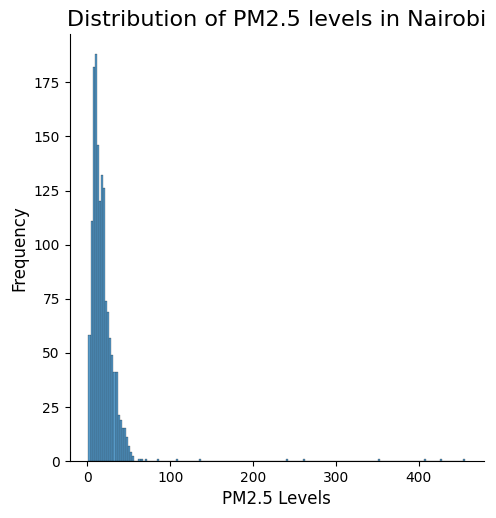

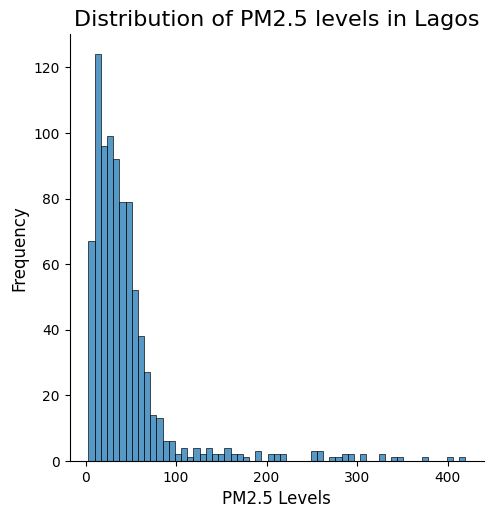

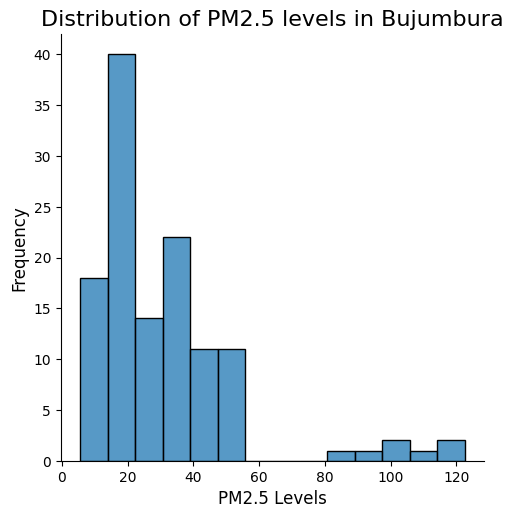

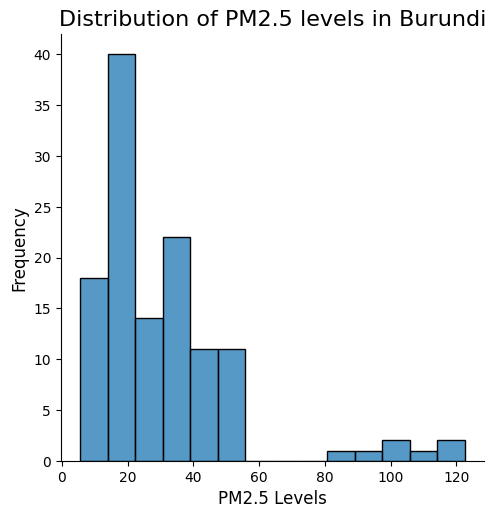

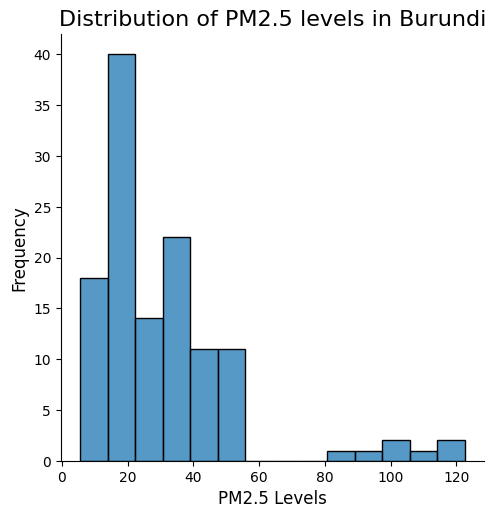

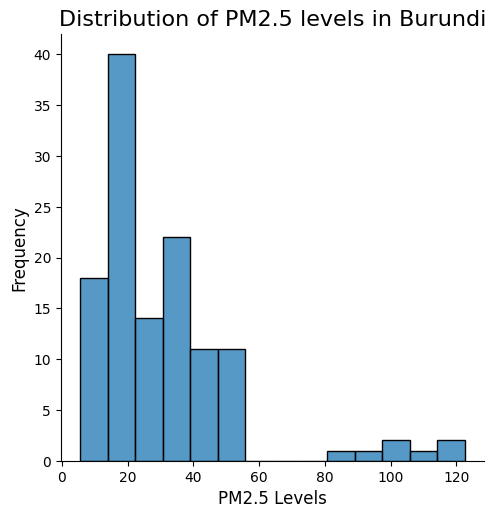

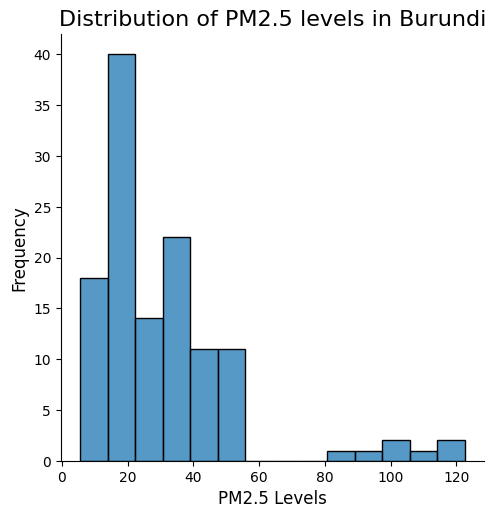

In [6]:
train[train['city']==city_list[0]]['pm2_5']
for i in range(0,len(city_list)):
    sns.displot(train[train['city']==city_list[i]]['pm2_5'])
    plt.title(f'Distribution of PM2.5 levels in {city_list[i]}', fontsize=16)
    plt.xlabel('PM2.5 Levels', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
for j in range(0,len(country_list)):
     sns.displot(train[train['city']==city_list[i]]['pm2_5'])
     plt.title(f'Distribution of PM2.5 levels in {country_list[i]}', fontsize=16)
     plt.xlabel('PM2.5 Levels', fontsize=12)
     plt.ylabel('Frequency', fontsize=12)

<Axes: xlabel='date_day', ylabel='pm2_5'>

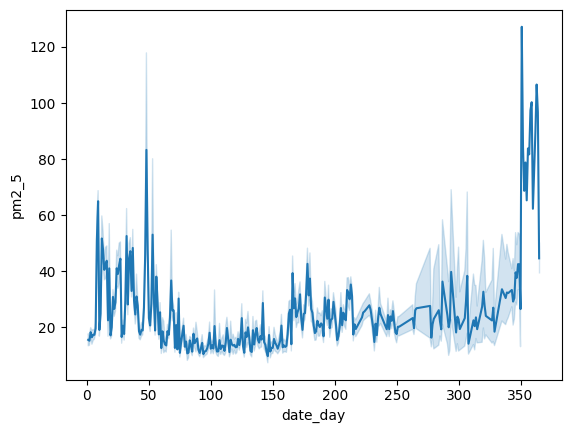

In [7]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

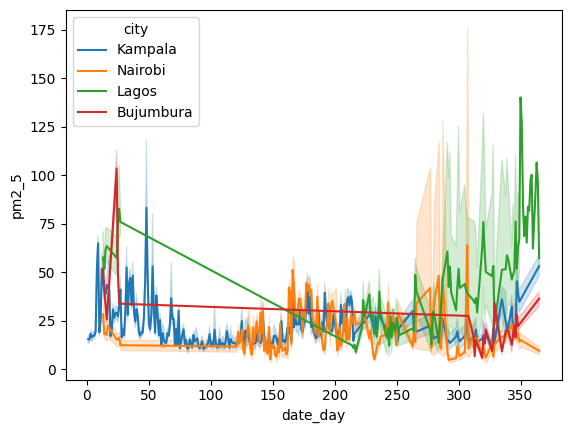

In [8]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['city'])

<Axes: xlabel='date_day', ylabel='pm2_5'>

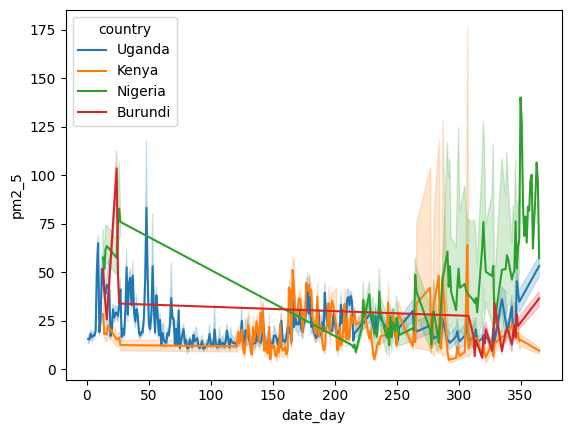

In [9]:
sns.lineplot(y=train['pm2_5'],x=train['date_day'],hue=train['country'])

<Axes: xlabel='date', ylabel='pm2_5'>

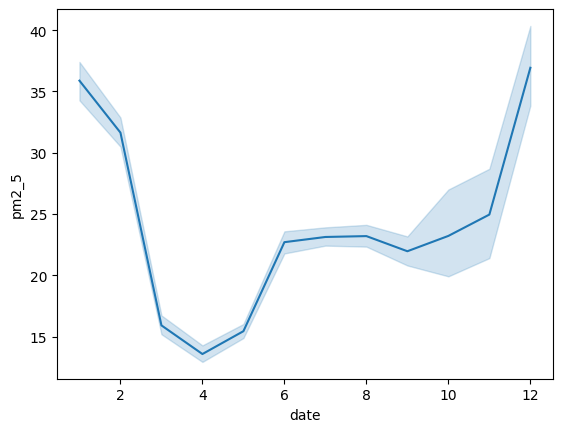

In [10]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'])

<Axes: xlabel='date', ylabel='pm2_5'>

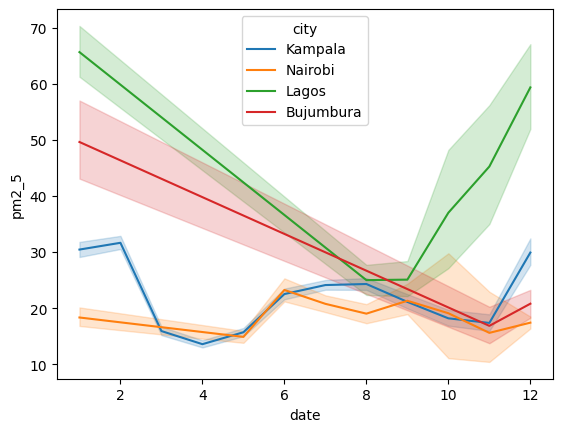

In [11]:
sns.lineplot(x=train['date'].dt.month,y=train['pm2_5'],hue=train['city'])

<Axes: xlabel='hour', ylabel='pm2_5'>

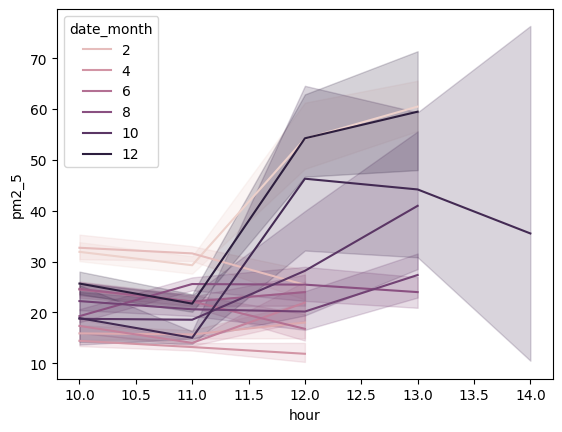

In [12]:
sns.lineplot(x=train['hour'],y=train['pm2_5'],hue=train['date_month'])

<Axes: xlabel='date', ylabel='pm2_5'>

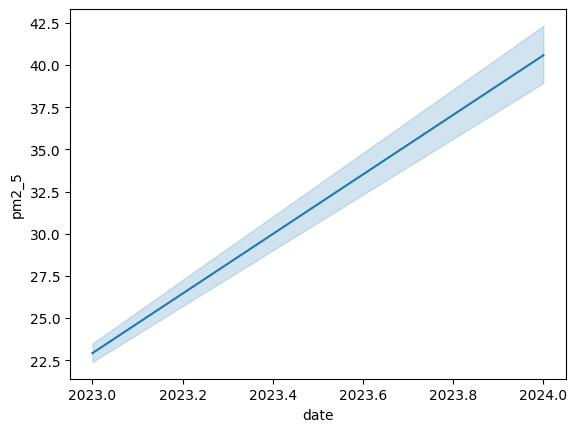

In [13]:
sns.lineplot(x=train['date'].dt.year,y=train['pm2_5'])

<Axes: xlabel='site_latitude', ylabel='site_longitude'>

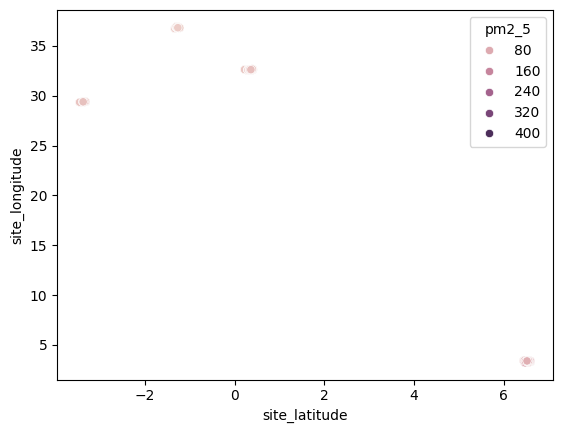

In [14]:
sns.scatterplot(x=train['site_latitude'],y=train['site_longitude'],hue=train['pm2_5'])

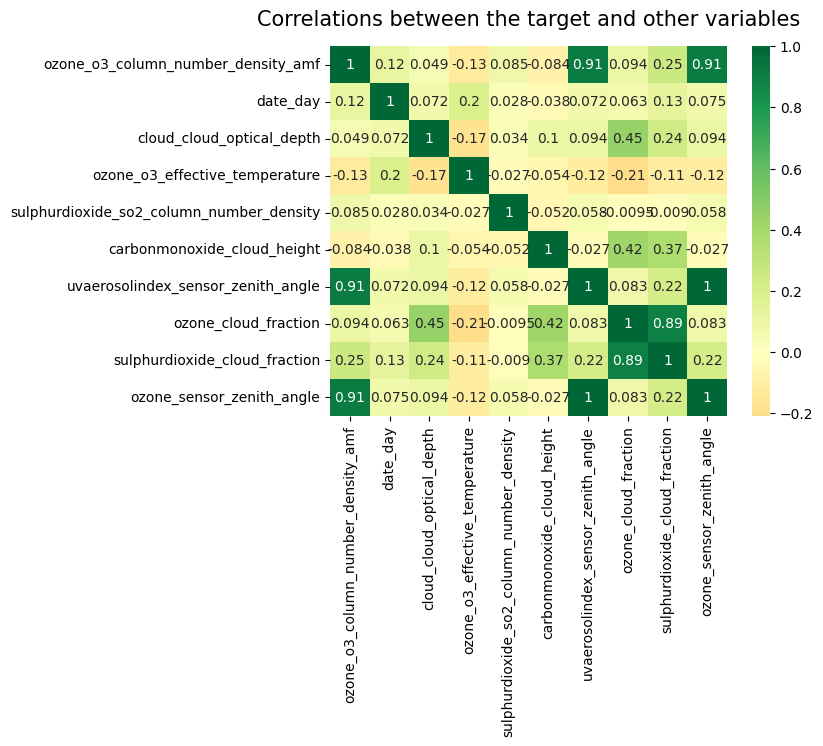

In [15]:
traintest = pd.concat([train,test])
# Select only numerical features
train_num_df = train.select_dtypes(include=['number'])
top10_corrs = abs(train_num_df.corr()['pm2_5']).sort_values(ascending = False).tail(10)
# top10_corrs += top10_corrs + train['pm2_5']
corr = train_num_df[list(top10_corrs.index)].corr()
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlations between the target and other variables', pad = 15, fontdict={'size': 15})
plt.show()

<Axes: >

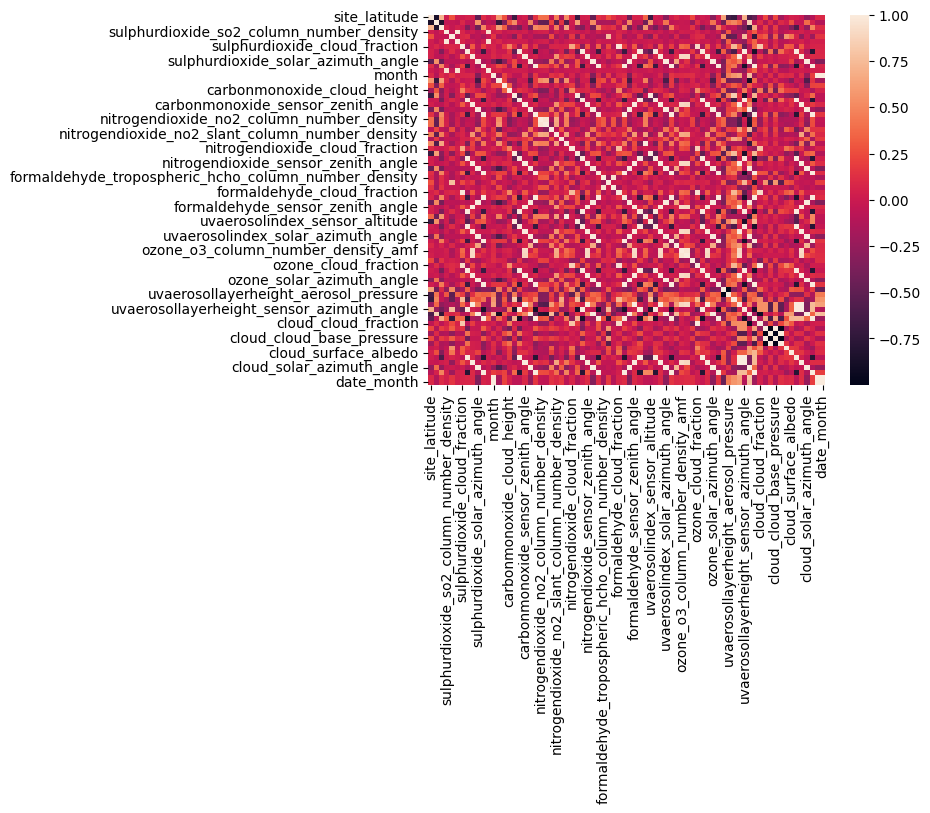

In [16]:
sns.heatmap(test.select_dtypes(include='number').corr(),linewidths=0.0028105)


city
Bujumbura    Axes(0.125,0.11;0.775x0.77)
Kampala      Axes(0.125,0.11;0.775x0.77)
Lagos        Axes(0.125,0.11;0.775x0.77)
Nairobi      Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

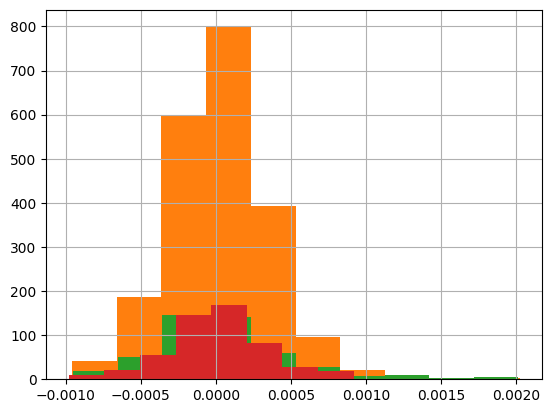

In [17]:
train.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

city
Accra      Axes(0.125,0.11;0.775x0.77)
Gulu       Axes(0.125,0.11;0.775x0.77)
Kisumu     Axes(0.125,0.11;0.775x0.77)
Yaoundé    Axes(0.125,0.11;0.775x0.77)
Name: sulphurdioxide_so2_column_number_density, dtype: object

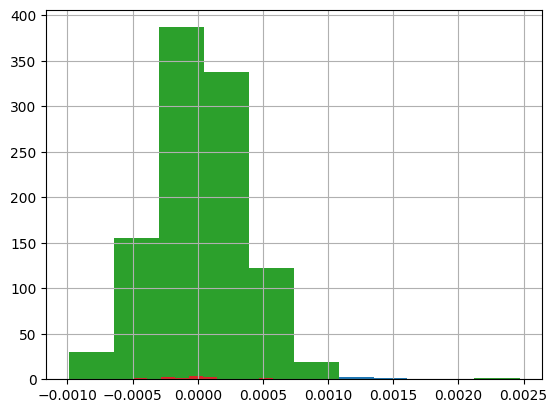

In [18]:
test.groupby('city')['sulphurdioxide_so2_column_number_density'].hist()

<Axes: xlabel='cloud_cloud_base_pressure', ylabel='pm2_5'>

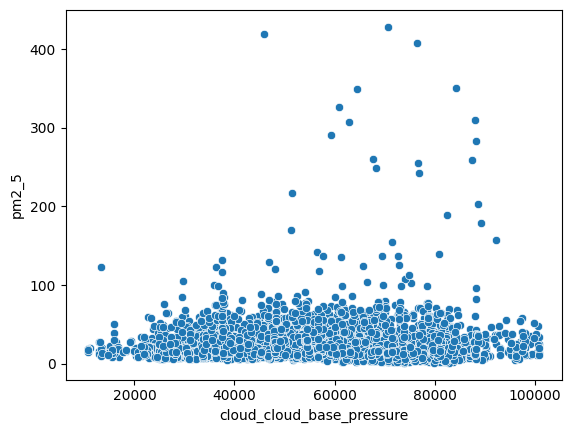

In [19]:
sns.scatterplot(x=train['cloud_cloud_base_pressure'],y=train['pm2_5'])

<Axes: xlabel='sulphurdioxide_so2_column_number_density', ylabel='pm2_5'>

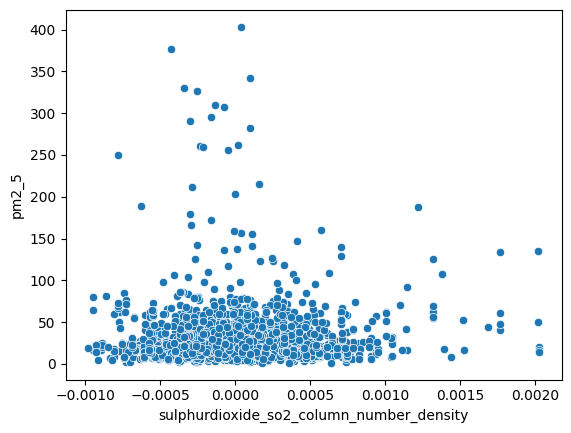

In [20]:
sns.scatterplot(x=train['sulphurdioxide_so2_column_number_density'],y=train['pm2_5'])

In [21]:
train[['pm2_5','nitrogendioxide_no2_slant_column_number_density']].corr()

,pm2_5,nitrogendioxide_no2_slant_column_number_density
pm2_5,1.000000,0.395134
nitrogendioxide_no2_slant_column_number_density,0.395134,1.000000


([<matplotlib.patches.Wedge at 0x237304516a0>,
 [Text(-0.1910130855889933, 1.083288512416601, ''),
  Text(-0.37622194259509467, -1.0336619611410558, ''),
  Text(0.9526280900645454, -0.5499997472908298, '')])

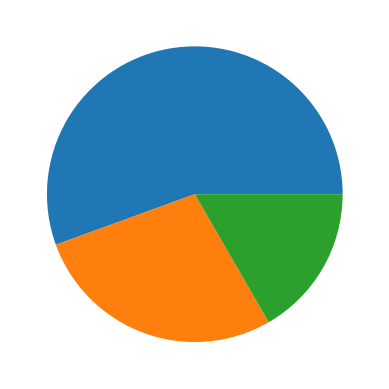

In [22]:
plt.pie([20,10,6])

<Axes: ylabel='hour'>

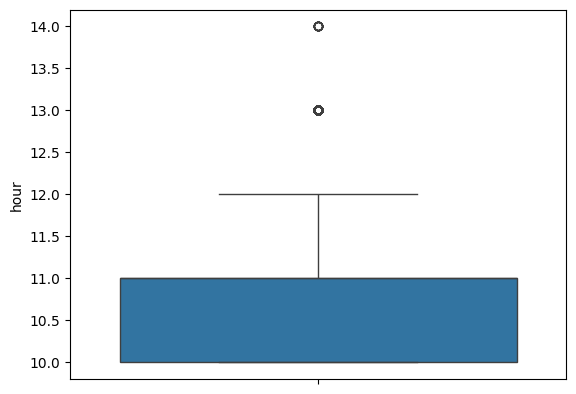

In [23]:
sns.boxplot(train['hour'])

In [24]:
def remove_nans(train, thresh):
    def nans_rate(train, col):
        return train[col].isna().sum() / train.shape[0]
    for col in train.columns:
        if nans_rate(train, col) >= thresh:
            train.drop(col, axis=1, inplace=True)
        else:
            train[col].fillna(method='bfill', inplace=True)
    return train

# Apply NaN handling
train = remove_nans(train, 0.7)
test = remove_nans(test, 0.7)
train.shape, test.shape

C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(method='bfill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train[col].fillna(method='bfill', inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\2112212201.py:8: FutureWarning: A value is trying to be set on a copy of a Da

((8071, 75), (2783, 74))

In [29]:
def drop_angle_cols(data_set):
    columns_to_drop = [col for col in data_set.columns if 'angle' in col]
    for col in columns_to_drop:
        data_set = data_set.drop(columns=[col])
    return data_set 

train_drop = drop_angle_cols(train)
test_drop = drop_angle_cols(test)
numerical_cols = train_drop.select_dtypes(include = "number").columns

Text(0.5, 1.0, 'Target Distribution')

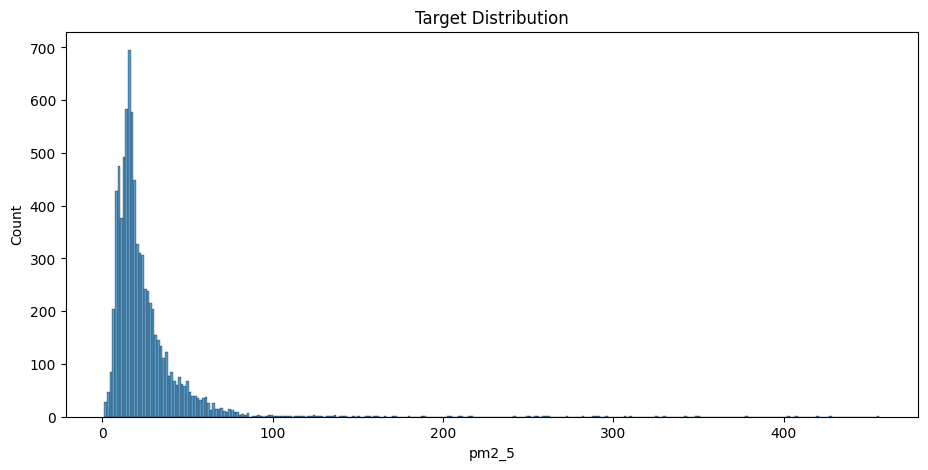

In [31]:
# target distribution
plt.figure(figsize = (11, 5))
sns.histplot(train_drop.pm2_5)
plt.title('Target Distribution')

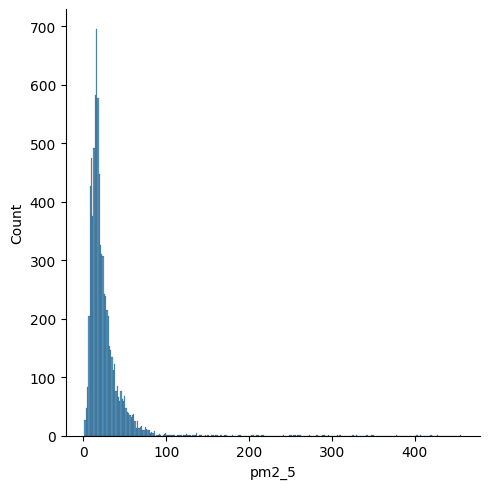

In [33]:
sns.displot((train.pm2_5))

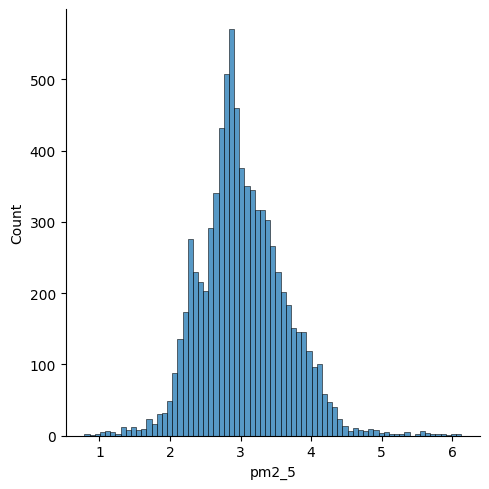

In [35]:
sns.displot(np.log1p(train.pm2_5))

In [36]:
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits = 4)
train_drop['folds'] = np.nan

# Generate the splits
for fold, (train_index, test_index) in enumerate(gkf.split(train_drop, groups=train['city']), 1):
    # Assign fold index to corresponding rows in the DataFrame
    train.loc[test_index, 'folds'] = fold

# Convert fold indices to integer type
train_drop['folds'] = train_drop['folds'].astype(int)
train_drop.groupby('folds')['pm2_5'].agg({'count'})

,count
folds,
1,5596
2,1500
3,852
4,123


In [43]:
class Config:
    id_col = "id"
    target_col = "pm2_5"

In [47]:
def feature_engineering(train_drop,test_drop):
    le = LabelEncoder()
     
    data = pd.concat([train_drop, test_drop])
    # capping before feature interactions
    skewed = ['pm2_5','hour']
    data[skewed].describe(percentiles=[0.05,0.95])
    
    #Feature interactions
    data['location'] = data['site_latitude'].astype('str') + '_' + data['site_longitude'].astype('str')
    data['sulphurdioxide_no2_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['carbonmonoxide_no2_interaction'] = data['carbonmonoxide_co_column_number_density'] + data['nitrogendioxide_no2_column_number_density']
    data['formaldehyde_ozone_interaction'] = data['formaldehyde_tropospheric_hcho_column_number_density'] + data['ozone_o3_column_number_density']
    
    data['sulphurdioxide_cloud_interaction'] = data['sulphurdioxide_so2_column_number_density'] + data['cloud_cloud_fraction']
    data['nitrogendioxide_cloud_interaction'] = data['nitrogendioxide_no2_column_number_density'] + data ['cloud_cloud_fraction']
    data['ozone_cloud_interaction'] = data['ozone_o3_column_number_density'] + data['cloud_cloud_fraction']
    
    data = data.sort_values(by = ['city','location', 'date', 'hour'])
    categorical_cols = data.select_dtypes(include='object').columns.tolist()
    high_cardinality = ['site_id']
    low_cardinality = ['city', 'country']
    #categorical_cols.remove('date')
    date_cols = ['date']
    numerical_cols = data.select_dtypes(exclude='object').columns.tolist()

    #fill in missing values BY grouping using the cities
    nan_cols = [col for col in numerical_cols if data[col].isnull().sum()>0 and col not in [Config.target_col, "folds"]]
    for col in nan_cols:
        data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='bfill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)

    #get date features
    for col in date_cols:
        data[col] = pd.to_datetime(data[col])
        data['month'] = data['date'].dt.month
        data['year'] = data['date'].dt.year
        data['quarter'] = data['date'].dt.quarter
        data['day'] = data['date'].dt.day
        data['week'] = data['date'].dt.isocalendar().week
        
        
    #label encode the cat features
    for col in high_cardinality + date_cols + ['location']:
        data[col] = le.fit_transform(data[col])


#   data = pd.get_dummies(data , columns = low_cardinality, drop_first= True, dtype=float)
    independent_features = [col for col in data.columns if col not in [Config.target_col, Config.id_col, 'folds', 'country', 'city','site_id','site_latitude','site_longitude' ]]
    dependent_feature = Config.target_col

    train  = data[data['id'].isin(train_drop['id'].unique())]
    test = data[data['id'].isin(test_drop['id'].unique())]

    return train, test, independent_features, dependent_feature

train_df, test_df, independent_features, dependent_feature = feature_engineering(train_drop, test_drop)

C:\Users\user\AppData\Local\Temp\ipykernel_8168\3873256015.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col].fillna(data[["location","city", col]].groupby(["city","location"]).shift(periods=0).fillna(method='bfill', limit=1).fillna(method='bfill', limit=1)[col], inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_8168\3873256015.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[["location","cit

In [50]:
training  = train_df[train_df['folds'].isin([1.0,3.0, 4.0])]

validation = train_df[train_df['folds'].isin([2.0])]
training.shape, validation.shape
((6571, 57), (1500, 57))
model = catt.CatBoostRegressor(random_state = 42, eval_metric = 'RMSE')
model.fit(training[independent_features], training[dependent_feature], eval_set = (validation[independent_features], validation[dependent_feature]), verbose = 100, early_stopping_rounds = 250 )

Learning rate set to 0.068433
0:	learn: 24.8937005	test: 21.3133739	best: 21.3133739 (0)	total: 409ms	remaining: 6m 48s
100:	learn: 15.1907751	test: 15.1708080	best: 15.1708080 (100)	total: 1.97s	remaining: 17.5s
200:	learn: 11.7629632	test: 14.4688720	best: 14.4688720 (200)	total: 3.27s	remaining: 13s
300:	learn: 9.8848030	test: 14.2552996	best: 14.2542158 (299)	total: 4.92s	remaining: 11.4s
400:	learn: 8.7456230	test: 14.0784879	best: 14.0784879 (400)	total: 6.7s	remaining: 10s
500:	learn: 7.8513236	test: 14.0260045	best: 14.0205431 (484)	total: 8.08s	remaining: 8.05s
600:	learn: 7.1452852	test: 13.9007360	best: 13.8996301 (593)	total: 9.64s	remaining: 6.4s
700:	learn: 6.6447861	test: 13.7903752	best: 13.7903752 (700)	total: 11.1s	remaining: 4.75s
800:	learn: 6.2157224	test: 13.7345412	best: 13.7192677 (720)	total: 12.7s	remaining: 3.16s
900:	learn: 5.8582671	test: 13.7076621	best: 13.7076621 (900)	total: 14.7s	remaining: 1.61s
999:	learn: 5.5374425	test: 13.6318330	best: 13.6315832 

In [51]:
def get_catt_varimp(model, train_columns, max_vars=350):

    # so using feature_importances_ property
    feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
    cv_varimp_df = pd.DataFrame([train_columns, feature_importances_perc]).T

    cv_varimp_df.columns = ['feature_name', 'varimp (%)']

    cv_varimp_df.sort_values(by='varimp (%)', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]

    return cv_varimp_df
#
get_catt_varimp(model, independent_features)

,feature_name,varimp (%)
40,location,48.61908
0,date,3.929557
8,carbonmonoxide_co_column_number_density,3.723163
42,carbonmonoxide_no2_interaction,3.448941
37,cloud_surface_albedo,2.547406
9,carbonmonoxide_h2o_column_number_density,2.281022
30,ozone_cloud_fraction,2.007101
24,uvaerosolindex_absorbing_aerosol_index,1.67297
50,week,1.487889
25,uvaerosolindex_sensor_altitude,1.479743


In [52]:
feature_importances_perc = (model.feature_importances_ / sum(model.feature_importances_)) * 100
cv_varimp_df = pd.DataFrame([independent_features, feature_importances_perc]).T
non_zero_features = cv_varimp_df[cv_varimp_df[1]> 0][0].values
non_zero_features

array(['date', 'hour', 'sulphurdioxide_so2_column_number_density',
       'sulphurdioxide_so2_column_number_density_amf',
       'sulphurdioxide_so2_slant_column_number_density',
       'sulphurdioxide_cloud_fraction',
       'sulphurdioxide_so2_column_number_density_15km', 'month',
       'carbonmonoxide_co_column_number_density',
       'carbonmonoxide_h2o_column_number_density',
       'carbonmonoxide_cloud_height', 'carbonmonoxide_sensor_altitude',
       'nitrogendioxide_no2_column_number_density',
       'nitrogendioxide_tropospheric_no2_column_number_density',
       'nitrogendioxide_stratospheric_no2_column_number_density',
       'nitrogendioxide_no2_slant_column_number_density',
       'nitrogendioxide_tropopause_pressure',
       'nitrogendioxide_absorbing_aerosol_index',
       'nitrogendioxide_cloud_fraction',
       'nitrogendioxide_sensor_altitude',
       'formaldehyde_tropospheric_hcho_column_number_density',
       'formaldehyde_tropospheric_hcho_column_number_density

In [55]:
corr = training[non_zero_features].corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i, j] >= 0.75:
            if columns[j]:
                columns[j] = False
selected_columns = training[non_zero_features].columns[columns]


In [56]:
from sklearn.preprocessing import StandardScaler

In [58]:
import optuna
# Define the objective function for Optuna
def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 31, 70),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'subsample': trial.suggest_uniform('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'random_state': 42
    }
    
    rmse_folds = []
    
    for fold in [1, 2, 3, 4]:
        print("*" * 100)
        df_train = train_df.copy()
        df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

        training = df_train[train_df['folds'] != fold]
        validation = df_train[df_train['folds'] == fold]

        # Training and evaluation
        y_train = training[dependent_feature]
        y_test = validation[dependent_feature]

        X_train = training[selected_columns]
        X_test = validation[selected_columns]

        model = lgb.LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
        
        preds = model.predict(X_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        rmse_folds.append(rmse)

    return np.mean(rmse_folds)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
best_params = study.best_params
print("Best hyperparameters found by Optuna:")
print(best_params)

# Train and evaluate the model using the best parameters
fold_pred = []
oof_pred = []

for fold in [1, 2, 3, 4]:
    print("*" * 100)
    df_train = train_df.copy()
    df_train[dependent_feature] = np.where(df_train[dependent_feature] >= df_train[dependent_feature].quantile(0.97), df_train[dependent_feature].quantile(0.97), df_train[dependent_feature])

    training = df_train[train_df['folds'] != fold]
    validation = df_train[df_train['folds'] == fold]

    # Training and evaluation
    y_train = training[dependent_feature]
    y_test = validation[dependent_feature]

    X_train = training[selected_columns]
    X_test = validation[selected_columns]

    model = lgb.LGBMRegressor(**best_params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    
    preds = model.predict(X_test)
    rmse = mean_squared_error(y_test, preds, squared=False)
    print(f"RMSE for fold {fold} with best params: {rmse}")
    oof_pred.append(rmse)

    # Inference
    test_preds = model.predict(test_df[selected_columns])
    fold_pred.append(test_preds)

print(f"The average RMSE across the 4 groups: {np.mean(oof_pred)}")

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-06-24 14:52:04,010] A new study created in memory with name: no-name-b9146966-4f9f-4494-a3fe-6218bbd5da2c
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'subsample':

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:52:16,837] Trial 0 finished with value: 7.792179107048191 and parameters: {'num_leaves': 68, 'learning_rate': 0.014093340310470746, 'n_estimators': 322, 'min_child_samples': 27, 'subsample': 0.9813019498876181, 'colsample_bytree': 0.8794156569826163, 'reg_alpha': 0.722916248550894, 'reg_lambda': 0.9435729381522665}. Best is trial 0 with value: 7.792179107048191.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:52:40,331] Trial 1 finished with value: 7.655439500330735 and parameters: {'num_leaves': 54, 'learning_rate': 0.02611665238570107, 'n_estimators': 524, 'min_child_samples': 85, 'subsample': 0.8232785227598255, 'colsample_bytree': 0.7846723793572971, 'reg_alpha': 0.9435664353524176, 'reg_lambda': 0.6469278936722193}. Best is trial 1 with value: 7.655439500330735.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:53:07,480] Trial 2 finished with value: 7.150486378718738 and parameters: {'num_leaves': 63, 'learning_rate': 0.043377757434388424, 'n_estimators': 533, 'min_child_samples': 24, 'subsample': 0.7713943546803705, 'colsample_bytree': 0.944862824553163, 'reg_alpha': 0.8737814022682333, 'reg_lambda': 0.7792540199147071}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:53:27,722] Trial 3 finished with value: 7.7135583912629295 and parameters: {'num_leaves': 36, 'learning_rate': 0.014445864853946461, 'n_estimators': 868, 'min_child_samples': 77, 'subsample': 0.9315343284498743, 'colsample_bytree': 0.8118594610411991, 'reg_alpha': 0.08035436817909158, 'reg_lambda': 0.8904127774064513}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:53:50,042] Trial 4 finished with value: 7.930486847141648 and parameters: {'num_leaves': 51, 'learning_rate': 0.023787978964051597, 'n_estimators': 412, 'min_child_samples': 91, 'subsample': 0.7441134365658498, 'colsample_bytree': 0.9321941664942457, 'reg_alpha': 0.9785118347904878, 'reg_lambda': 0.04454844480080422}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:54:00,709] Trial 5 finished with value: 8.124245957470015 and parameters: {'num_leaves': 39, 'learning_rate': 0.016609636789481814, 'n_estimators': 474, 'min_child_samples': 94, 'subsample': 0.8975990654335171, 'colsample_bytree': 0.9863128717287101, 'reg_alpha': 0.6423111276778375, 'reg_lambda': 0.2725735331758037}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:54:16,898] Trial 6 finished with value: 7.73685226621328 and parameters: {'num_leaves': 61, 'learning_rate': 0.022736344919690937, 'n_estimators': 331, 'min_child_samples': 63, 'subsample': 0.7166324921325423, 'colsample_bytree': 0.9541034045340226, 'reg_alpha': 0.13776178171247688, 'reg_lambda': 0.8516932987093752}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:54:33,959] Trial 7 finished with value: 7.581329038636814 and parameters: {'num_leaves': 49, 'learning_rate': 0.01506791714363339, 'n_estimators': 670, 'min_child_samples': 51, 'subsample': 0.984676716546186, 'colsample_bytree': 0.9689551292259699, 'reg_alpha': 0.2471315430226375, 'reg_lambda': 0.4617562282880644}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rat

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:54:39,016] Trial 8 finished with value: 8.03714328560762 and parameters: {'num_leaves': 64, 'learning_rate': 0.037075024193989385, 'n_estimators': 110, 'min_child_samples': 47, 'subsample': 0.7114776280493392, 'colsample_bytree': 0.9038746812985358, 'reg_alpha': 0.030879959796417555, 'reg_lambda': 0.5096245989211866}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:55:07,692] Trial 9 finished with value: 7.404271852474126 and parameters: {'num_leaves': 49, 'learning_rate': 0.021560271660084656, 'n_estimators': 949, 'min_child_samples': 69, 'subsample': 0.8545505313434123, 'colsample_bytree': 0.9602418115990558, 'reg_alpha': 0.7109376379344718, 'reg_lambda': 0.11229131661092118}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:55:31,111] Trial 10 finished with value: 7.1603539106650995 and parameters: {'num_leaves': 70, 'learning_rate': 0.06398567099535657, 'n_estimators': 711, 'min_child_samples': 24, 'subsample': 0.7795232922559596, 'colsample_bytree': 0.7196767968460918, 'reg_alpha': 0.4454762569795048, 'reg_lambda': 0.7161036073351787}. Best is trial 2 with value: 7.150486378718738.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:55:59,341] Trial 11 finished with value: 7.127450955934938 and parameters: {'num_leaves': 70, 'learning_rate': 0.07364405964525837, 'n_estimators': 727, 'min_child_samples': 25, 'subsample': 0.7906787800806923, 'colsample_bytree': 0.7158765969058069, 'reg_alpha': 0.4207818563109494, 'reg_lambda': 0.6924435634308564}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:56:17,265] Trial 12 finished with value: 7.3348920746199235 and parameters: {'num_leaves': 59, 'learning_rate': 0.0819395976074321, 'n_estimators': 710, 'min_child_samples': 38, 'subsample': 0.7949056837938678, 'colsample_bytree': 0.7006497894947757, 'reg_alpha': 0.40044224911073156, 'reg_lambda': 0.6918602679529466}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:56:39,109] Trial 13 finished with value: 7.137957509838368 and parameters: {'num_leaves': 65, 'learning_rate': 0.04653578765240833, 'n_estimators': 623, 'min_child_samples': 21, 'subsample': 0.771963589693487, 'colsample_bytree': 0.834914461209708, 'reg_alpha': 0.5679932487011745, 'reg_lambda': 0.5218686131897114}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004394 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:57:11,563] Trial 14 finished with value: 7.295369535548619 and parameters: {'num_leaves': 70, 'learning_rate': 0.05692340537684251, 'n_estimators': 823, 'min_child_samples': 38, 'subsample': 0.8524597988029078, 'colsample_bytree': 0.7562447193712486, 'reg_alpha': 0.5663019026589928, 'reg_lambda': 0.49962142286787065}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002598 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:57:33,749] Trial 15 finished with value: 7.304115765419903 and parameters: {'num_leaves': 57, 'learning_rate': 0.09386837501746562, 'n_estimators': 652, 'min_child_samples': 35, 'subsample': 0.8121012780809856, 'colsample_bytree': 0.8383383129414499, 'reg_alpha': 0.28998632271194497, 'reg_lambda': 0.3148121001834331}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:58:10,235] Trial 16 finished with value: 7.262145881118884 and parameters: {'num_leaves': 66, 'learning_rate': 0.05111066667001965, 'n_estimators': 837, 'min_child_samples': 50, 'subsample': 0.7590981808597291, 'colsample_bytree': 0.7549048058647319, 'reg_alpha': 0.5278002230479704, 'reg_lambda': 0.5745864399080405}. Best is trial 11 with value: 7.127450955934938.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:58:31,007] Trial 17 finished with value: 7.094970771141771 and parameters: {'num_leaves': 41, 'learning_rate': 0.07166710428844367, 'n_estimators': 608, 'min_child_samples': 20, 'subsample': 0.88208925068917, 'colsample_bytree': 0.8567237747174431, 'reg_alpha': 0.3149485178944683, 'reg_lambda': 0.3490047229810169}. Best is trial 17 with value: 7.094970771141771.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:58:59,067] Trial 18 finished with value: 7.242669645943263 and parameters: {'num_leaves': 43, 'learning_rate': 0.07250441003659874, 'n_estimators': 788, 'min_child_samples': 32, 'subsample': 0.9102959801723199, 'colsample_bytree': 0.8694076662374094, 'reg_alpha': 0.3207867461760142, 'reg_lambda': 0.3264652472358839}. Best is trial 17 with value: 7.094970771141771.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:59:19,509] Trial 19 finished with value: 7.266119280971244 and parameters: {'num_leaves': 42, 'learning_rate': 0.09965282701016201, 'n_estimators': 1000, 'min_child_samples': 45, 'subsample': 0.8833576909460089, 'colsample_bytree': 0.8012970300630622, 'reg_alpha': 0.1545182089754092, 'reg_lambda': 0.3898833747040401}. Best is trial 17 with value: 7.094970771141771.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017380 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
****************************************************************************************************


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:59:24,735] Trial 20 finished with value: 8.048594945629173 and parameters: {'num_leaves': 31, 'learning_rate': 0.03319930624507767, 'n_estimators': 212, 'min_child_samples': 57, 'subsample': 0.9451972062948165, 'colsample_bytree': 0.9040873832617282, 'reg_alpha': 0.38355923372732115, 'reg_lambda': 0.2369144755498116}. Best is trial 17 with value: 7.094970771141771.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:59:38,397] Trial 21 finished with value: 7.092655755998211 and parameters: {'num_leaves': 46, 'learning_rate': 0.046808851614233975, 'n_estimators': 612, 'min_child_samples': 21, 'subsample': 0.8392160811590141, 'colsample_bytree': 0.8404681495612063, 'reg_alpha': 0.5078910267641262, 'reg_lambda': 0.6110826282255236}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001641 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 14:59:52,619] Trial 22 finished with value: 7.115830733822995 and parameters: {'num_leaves': 45, 'learning_rate': 0.06648959654205208, 'n_estimators': 617, 'min_child_samples': 20, 'subsample': 0.8344427568092647, 'colsample_bytree': 0.856223767292279, 'reg_alpha': 0.21992061580497968, 'reg_lambda': 0.6167441293843916}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001809 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:00:06,876] Trial 23 finished with value: 7.199645054452542 and parameters: {'num_leaves': 44, 'learning_rate': 0.05954352974933028, 'n_estimators': 590, 'min_child_samples': 31, 'subsample': 0.8694477283827171, 'colsample_bytree': 0.8617270607578135, 'reg_alpha': 0.20875521978967737, 'reg_lambda': 0.6125014969865443}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000797 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:00:21,237] Trial 24 finished with value: 7.947096412145605 and parameters: {'num_leaves': 46, 'learning_rate': 0.010363562185772572, 'n_estimators': 438, 'min_child_samples': 20, 'subsample': 0.8321980950864201, 'colsample_bytree': 0.8960494522557402, 'reg_alpha': 0.3432485173869818, 'reg_lambda': 0.406707270721641}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:00:31,265] Trial 25 finished with value: 7.329513404440501 and parameters: {'num_leaves': 38, 'learning_rate': 0.04315926185100453, 'n_estimators': 573, 'min_child_samples': 40, 'subsample': 0.87542093790767, 'colsample_bytree': 0.8259822754501933, 'reg_alpha': 0.4752983943253355, 'reg_lambda': 0.16322402624628285}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:00:39,264] Trial 26 finished with value: 7.267031052017333 and parameters: {'num_leaves': 35, 'learning_rate': 0.0662086762467605, 'n_estimators': 372, 'min_child_samples': 30, 'subsample': 0.8302172123851517, 'colsample_bytree': 0.8522211079229042, 'reg_alpha': 0.24967289065028286, 'reg_lambda': 0.7738591549981719}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:00:49,686] Trial 27 finished with value: 7.1210448044031684 and parameters: {'num_leaves': 46, 'learning_rate': 0.08247439574253304, 'n_estimators': 502, 'min_child_samples': 20, 'subsample': 0.9200493484594832, 'colsample_bytree': 0.7899408820225822, 'reg_alpha': 0.1585735139009809, 'reg_lambda': 0.5557658886530905}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:01:02,235] Trial 28 finished with value: 7.2134338253196555 and parameters: {'num_leaves': 41, 'learning_rate': 0.05302557127257561, 'n_estimators': 611, 'min_child_samples': 29, 'subsample': 0.8449222475838457, 'colsample_bytree': 0.8865751898265403, 'reg_alpha': 0.32322141134524734, 'reg_lambda': 0.42699189065782794}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learni

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:01:20,056] Trial 29 finished with value: 7.294782633848802 and parameters: {'num_leaves': 53, 'learning_rate': 0.03718796470088269, 'n_estimators': 773, 'min_child_samples': 42, 'subsample': 0.8928656333441986, 'colsample_bytree': 0.7679924663542376, 'reg_alpha': 0.6194888119786586, 'reg_lambda': 0.9359495533879845}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:01:31,910] Trial 30 finished with value: 7.3488265245135675 and parameters: {'num_leaves': 45, 'learning_rate': 0.028248144854439054, 'n_estimators': 462, 'min_child_samples': 27, 'subsample': 0.9697282018994935, 'colsample_bytree': 0.9212296697669646, 'reg_alpha': 0.7784214589208134, 'reg_lambda': 0.6198738235663421}. Best is trial 21 with value: 7.092655755998211.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learnin

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:01:44,724] Trial 31 finished with value: 7.05052756692979 and parameters: {'num_leaves': 46, 'learning_rate': 0.08129779942524641, 'n_estimators': 523, 'min_child_samples': 20, 'subsample': 0.919551220348854, 'colsample_bytree': 0.8130463668282744, 'reg_alpha': 0.17084564190411414, 'reg_lambda': 0.5507459244020112}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:01:57,255] Trial 32 finished with value: 7.205866593798979 and parameters: {'num_leaves': 47, 'learning_rate': 0.08448247885294907, 'n_estimators': 512, 'min_child_samples': 33, 'subsample': 0.9529599890739626, 'colsample_bytree': 0.8186791269165149, 'reg_alpha': 0.09114157629512332, 'reg_lambda': 0.3603270729902216}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:02:15,190] Trial 33 finished with value: 7.157577070130596 and parameters: {'num_leaves': 40, 'learning_rate': 0.0703625876928989, 'n_estimators': 562, 'min_child_samples': 27, 'subsample': 0.8098987684672974, 'colsample_bytree': 0.847568618208182, 'reg_alpha': 0.21541497044836122, 'reg_lambda': 0.4652529128302755}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:02:31,432] Trial 34 finished with value: 7.499891957884722 and parameters: {'num_leaves': 54, 'learning_rate': 0.045956538348268024, 'n_estimators': 666, 'min_child_samples': 100, 'subsample': 0.9115327425349897, 'colsample_bytree': 0.8678158867275823, 'reg_alpha': 0.0018160105193105736, 'reg_lambda': 0.7607862828024938}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learn

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:02:37,118] Trial 35 finished with value: 7.255940104638429 and parameters: {'num_leaves': 36, 'learning_rate': 0.05941351590563512, 'n_estimators': 283, 'min_child_samples': 23, 'subsample': 0.8645841973613182, 'colsample_bytree': 0.8122197707861369, 'reg_alpha': 0.08632109112203776, 'reg_lambda': 0.6476070797793287}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:02:51,532] Trial 36 finished with value: 7.371448325520449 and parameters: {'num_leaves': 51, 'learning_rate': 0.08975225999657753, 'n_estimators': 530, 'min_child_samples': 77, 'subsample': 0.9306879496935124, 'colsample_bytree': 0.7802158135868764, 'reg_alpha': 0.36431462279973326, 'reg_lambda': 0.5529399755121809}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:03:04,115] Trial 37 finished with value: 7.309478186729073 and parameters: {'num_leaves': 48, 'learning_rate': 0.0751025857928583, 'n_estimators': 555, 'min_child_samples': 35, 'subsample': 0.8932722452438169, 'colsample_bytree': 0.8809599648418226, 'reg_alpha': 0.28043501438868246, 'reg_lambda': 0.21840067974384703}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:03:23,986] Trial 38 finished with value: 7.380855990361651 and parameters: {'num_leaves': 32, 'learning_rate': 0.04061237159260731, 'n_estimators': 392, 'min_child_samples': 26, 'subsample': 0.8399788798742887, 'colsample_bytree': 0.8006020542147743, 'reg_alpha': 0.17816330690595897, 'reg_lambda': 0.8657875916055068}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002857 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:03:43,979] Trial 39 finished with value: 7.143643440329224 and parameters: {'num_leaves': 38, 'learning_rate': 0.05103771723513592, 'n_estimators': 634, 'min_child_samples': 23, 'subsample': 0.8155826013476024, 'colsample_bytree': 0.8490596632522118, 'reg_alpha': 0.5018163083441509, 'reg_lambda': 0.6553121279889036}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:03:58,143] Trial 40 finished with value: 7.35172956596405 and parameters: {'num_leaves': 51, 'learning_rate': 0.06139205103095594, 'n_estimators': 479, 'min_child_samples': 58, 'subsample': 0.860591969055268, 'colsample_bytree': 0.9233363686391866, 'reg_alpha': 0.10332484778395741, 'reg_lambda': 0.013808144943787903}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:04:10,182] Trial 41 finished with value: 7.135272862796308 and parameters: {'num_leaves': 45, 'learning_rate': 0.07881502744060884, 'n_estimators': 506, 'min_child_samples': 20, 'subsample': 0.9290688053891091, 'colsample_bytree': 0.7953606818161839, 'reg_alpha': 0.14572224673285727, 'reg_lambda': 0.560949215252043}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:04:39,171] Trial 42 finished with value: 7.1019404860821815 and parameters: {'num_leaves': 47, 'learning_rate': 0.08196006720893065, 'n_estimators': 597, 'min_child_samples': 21, 'subsample': 0.9048973902763277, 'colsample_bytree': 0.826589402516497, 'reg_alpha': 0.19660781012242076, 'reg_lambda': 0.5906193535259674}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:04:56,420] Trial 43 finished with value: 7.209307756215878 and parameters: {'num_leaves': 42, 'learning_rate': 0.06566820258621608, 'n_estimators': 688, 'min_child_samples': 28, 'subsample': 0.9032100846422735, 'colsample_bytree': 0.8352777106838812, 'reg_alpha': 0.050713240421107364, 'reg_lambda': 0.4698642509028107}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:05:32,909] Trial 44 finished with value: 7.1750040082586874 and parameters: {'num_leaves': 48, 'learning_rate': 0.0934491593116709, 'n_estimators': 750, 'min_child_samples': 24, 'subsample': 0.8829736651593934, 'colsample_bytree': 0.8215676073832024, 'reg_alpha': 0.22056533139849643, 'reg_lambda': 0.8060862470014263}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:05:49,295] Trial 45 finished with value: 7.35398705773453 and parameters: {'num_leaves': 53, 'learning_rate': 0.08483747694990039, 'n_estimators': 581, 'min_child_samples': 35, 'subsample': 0.9491698469630414, 'colsample_bytree': 0.8524203128606369, 'reg_alpha': 0.2723019578031979, 'reg_lambda': 0.7252424234510362}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:06:01,295] Trial 46 finished with value: 7.374140163025387 and parameters: {'num_leaves': 50, 'learning_rate': 0.06901266234725091, 'n_estimators': 643, 'min_child_samples': 83, 'subsample': 0.8809165602955655, 'colsample_bytree': 0.8638998540089363, 'reg_alpha': 0.4400822427657083, 'reg_lambda': 0.6143019765426256}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:06:11,795] Trial 47 finished with value: 7.131547812196674 and parameters: {'num_leaves': 56, 'learning_rate': 0.05451325416690122, 'n_estimators': 438, 'min_child_samples': 23, 'subsample': 0.851017897003233, 'colsample_bytree': 0.7782558966375734, 'reg_alpha': 0.6914449385281527, 'reg_lambda': 0.5140385176743014}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_ra

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:06:26,599] Trial 48 finished with value: 7.307104514503305 and parameters: {'num_leaves': 44, 'learning_rate': 0.018758113484931924, 'n_estimators': 682, 'min_child_samples': 20, 'subsample': 0.9680404231093178, 'colsample_bytree': 0.8315807198338575, 'reg_alpha': 0.7891500078120861, 'reg_lambda': 0.6784687270624076}. Best is trial 31 with value: 7.05052756692979.
C:\Users\user\AppData\Local\Temp\ipykernel_8168\1551277643.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_

****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
[I 2024-06-24 15:06:37,008] Trial 49 finished with value: 7.153536816711273 and parameters: {'num_leaves': 40, 'learning_rate': 0.048636774082890695, 'n_estimators': 612, 'min_child_samples': 26, 'subsample': 0.7995690554425698, 'colsample_bytree': 0.8091534009333623, 'reg_alpha': 0.19409790840805796, 'reg_lambda': 0.6032232366283498}. Best is trial 31 with value: 7.05052756692979.


Best hyperparameters found by Optuna:
{'num_leaves': 46, 'learning_rate': 0.08129779942524641, 'n_estimators': 523, 'min_child_samples': 20, 'subsample': 0.919551220348854, 'colsample_bytree': 0.8130463668282744, 'reg_alpha': 0.17084564190411414, 'reg_lambda': 0.5507459244020112}
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7222
[LightGBM] [Info] Number of data points in the train set: 2475, number of used features: 33
[LightGBM] [Info] Start training from score 22.078161


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 1 with best params: 10.072150070116846
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7247
[LightGBM] [Info] Number of data points in the train set: 6571, number of used features: 33
[LightGBM] [Info] Start training from score 23.266612


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 2 with best params: 7.098929853744156
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7248
[LightGBM] [Info] Number of data points in the train set: 7219, number of used features: 33
[LightGBM] [Info] Start training from score 23.198879


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


RMSE for fold 3 with best params: 6.2520794416563525
****************************************************************************************************
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7246
[LightGBM] [Info] Number of data points in the train set: 7948, number of used features: 33
[LightGBM] [Info] Start training from score 23.039806
RMSE for fold 4 with best params: 5.082466866179752
The average RMSE across the 4 groups: 7.126406557924277


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Text(0.5, 1.0, 'CatBoostClassifier features importance (top 50):')

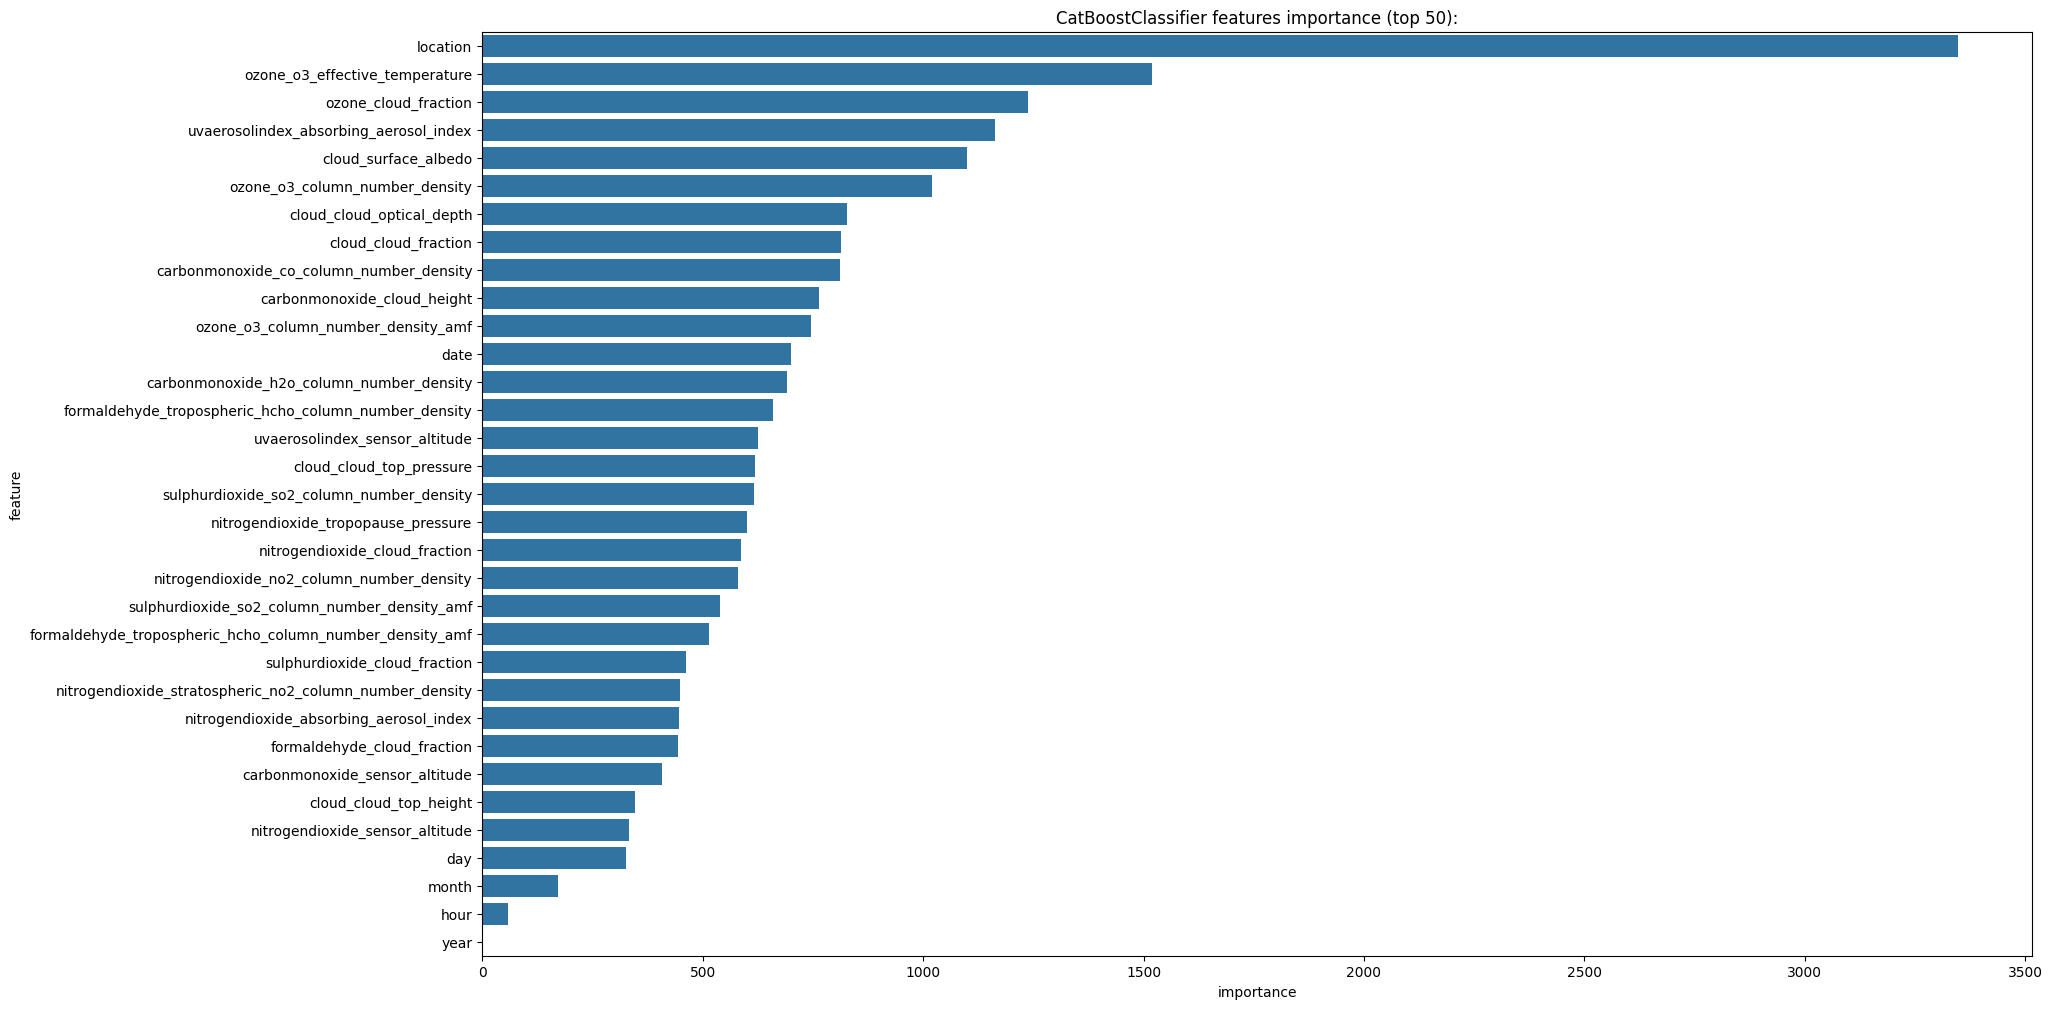

In [59]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = selected_columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(60))
plt.title('CatBoostClassifier features importance (top 50):')

In [60]:
pred = np.mean(fold_pred, axis = 0)
len(pred)
test_df['pred'] = pred
sub = test_df[['id', 'pred']]
sub.head()

,id,pred
214,id_yorywxet0a,18.543402
215,id_9rhbkh8kye,16.370672
216,id_oh2pg7ik9m,16.642685
217,id_u5xtrnbshq,16.598417
218,id_pfcdhqpggy,17.778952


In [61]:
sub.to_csv('submit64.csv', index= False)